In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from experiment import solve_value_function, solve_alternative_ME
from model import ode_y, ode_y_jump_approach_one_boundary, uncertainty_decomposition
from simulation import simulation
from utilities import find_nearest_value
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
# Simulate capital process
# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
η = .032
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

## SCC and Uncertainty

In [3]:
ξ_w = .3
ξ_p = .3
ξ_a = 100000.

n_model = 40
damage_setting={'γ_2p': np.linspace(0, 1./3, n_model),
                'πd_o': np.ones(n_model)/n_model}

ϵ = 5.
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)

σ_y = 1.2*np.mean(θ)
y_bar = 1.6
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_step = .02
y_grid_long = np.arange(0., y_bar*2, y_step)
y_grid_short = np.arange(0., y_bar+y_step, y_step)
n_bar = find_nearest_value(y_grid_long, y_bar) + 1

# Uncertainty decomposition
n_temp = 16
n_carb = 9
θ_reshape = θ.reshape(n_temp, n_carb)
θ_temp = np.mean(θ_reshape, axis=1)
θ_carb = np.mean(θ_reshape, axis=0)
πc_o_temp = np.ones_like(θ_temp)/len(θ_temp)
πc_o_carb = np.ones_like(θ_carb)/len(θ_carb)

# Prepare ϕ_i (carbon + temperature)
ϕ_list = []
for i, γ_2p_i in enumerate(γ_2p):
    print(i)
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=1_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_carb_temp = np.array(ϕ_list_short)

# Prepare ϕ_i (baseline)
ϕ_list = []
for i, γ_2p_i in enumerate(γ_2p):
    print(i)
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, 1000., γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=1_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_baseline = np.array(ϕ_list_short)

# Compute ϕ
ς = .25
model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i_carb_temp, πd_o)
model_res = ode_y_jump_approach_one_boundary(y_grid_short, model_paras, 
                                             v0=np.average(ϕ_i_carb_temp, weights=πd_o, axis=0),
                                             ϵ=ϵ, tol=1e-8, max_iter=2_000, print_all=False)

ME_total = η/model_res['e_tilde']

# Solve baseline
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_baseline, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=np.ones_like(model_res['πc'])/len(θ),
                                          bc=np.average(ϕ_i_baseline, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=2_000, print_all=False)  
ME_baseline = model_res_new['ME']

0
Converged. Total iteration 1000: LHS Error: 7.3248954011617686e-06; RHS Error 8.359601803771544e-05
1
Converged. Total iteration 1000: LHS Error: 1.4875424768945323e-05; RHS Error 0.00012601415935523108
2
Converged. Total iteration 1000: LHS Error: 1.2435490627016321e-05; RHS Error 0.00022329541512822876
3
Converged. Total iteration 1000: LHS Error: 1.0498068247688508e-05; RHS Error 0.00029758255511340426
4
Converged. Total iteration 1000: LHS Error: 1.7148209288997407e-05; RHS Error 0.0003609088217637474
5
Converged. Total iteration 1000: LHS Error: 7.18633040199812e-06; RHS Error 0.00041579754656919515
6
Converged. Total iteration 1000: LHS Error: 1.3400543416830501e-05; RHS Error 0.00046500024522366096
7
Converged. Total iteration 1000: LHS Error: 6.871201316105413e-06; RHS Error 0.0005109037620190313
8
Converged. Total iteration 1000: LHS Error: 9.652001298343648e-06; RHS Error 0.0005524817993948286
9
Converged. Total iteration 1000: LHS Error: 8.48596681182201e-06; RHS Error 0.0

Converged. Total iteration 2000: LHS Error: 1.8962888553630818e-06; RHS Error 0.24109668374790408


In [4]:
y_grid_short.shape

(81,)

In [5]:
def simulation_me(y_grid, e_grid, ratio_grid, θ=1.86/1000., y_start=.5394, T=50):
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    ratio_t = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        ratio_t[i] = np.interp(y_start, y_grid, ratio_grid)
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
    return Et, yt, ratio_t

et, yt, ht, gt = simulation(model_res['y_grid'], model_res['e_tilde'], model_res['h'], model_res['g'],
                            θ=np.mean(model_res['θ']), y_start=1.1, T=80)

_, _, ratio_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      ME_baseline/ME_total, θ=np.mean(θ), y_start=1.1, T=80)

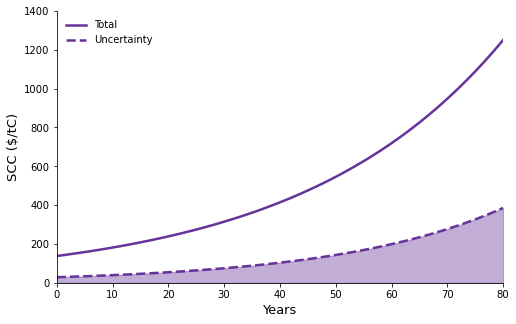

In [8]:
SCCt_all = η*(0.025)*Kt[:81]/((1.-η)*et) * 1000
SCCt_baseline = SCCt_all * ratio_t
SCCt_uncertainty = SCCt_all - SCCt_baseline

plt.figure(figsize=(8, 5))
plt.plot(SCCt_all, color='rebeccapurple', label='Total', linewidth=2.5)
plt.plot(SCCt_uncertainty, color='rebeccapurple', label='Uncertainty', linestyle='dashed', linewidth=2.5)
plt.fill_between(np.arange(0, 81, 1), np.zeros_like(SCCt_uncertainty), 
                 SCCt_uncertainty, color='rebeccapurple', alpha=.4)
plt.ylim(0, 1400)
plt.xlim(0, 80)
plt.xlabel('Years', fontsize=13)
plt.ylabel('SCC ($/tC)', fontsize=13)
plt.legend(frameon=False, loc='upper left')
# plt.savefig('../plots/scc.pdf')